In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from internal.utils.colmap import read_points3D_binary, read_images_binary, read_cameras_binary, qvec2rotmat, rotmat2qvec, Point3D, Camera, BaseImage

In [3]:
aerail_pcd_path = '../data/dji_test/hongkong/ex0102_aerial/sparse/0/points3D.bin'
aerial_img_path = '../data/dji_test/hongkong/ex0102_aeiral/sparse/0/images.bin'
aerial_cam_path = '../data/dji_test/hongkong/ex0102_aerial/sparse/0/cameras.bin'
phone_pcd_path = '../data/dji_test/hongkong/ex0102_phone/sparse/0/points3D.bin'
phone_img_path = '../data/dji_test/hongkong/ex0102_phone/sparse/0/images.bin'
phone_cam_path = '../data/dji_test/hongkong/ex0102_phone/sparse/0/cameras.bin'

# note all points are under respective world coordinates
aerial_points = read_points3D_binary(aerail_pcd_path)
phone_points = read_points3D_binary(phone_pcd_path)

aerial_intrinsic = read_cameras_binary(aerial_cam_path)
phone_intrinsic = read_cameras_binary(phone_cam_path)

aerial_cameras = read_images_binary(aerial_img_path)
phone_cameras = read_images_binary(phone_img_path)

(-50.0, 50.0)

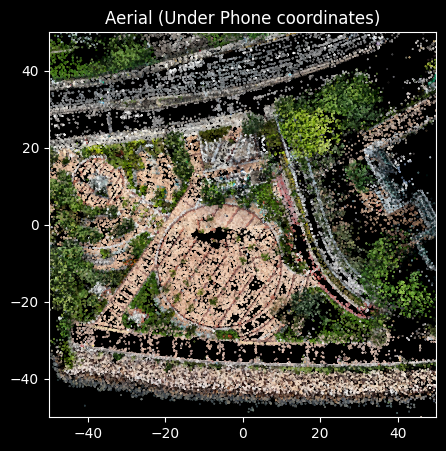

In [3]:
# points change idx, xyz, change change image_ids
# cameras change point3D_ids, id, qvec and tvec
# src: aerial, tgt: phone

aerial2phone = np.array([
    [2.922504,3.289219,-2.268028,-9.628083],
    [-0.002880,2.811760,4.074057,-37.961544],
    [3.995361,-2.403952,1.661942,2.546913],
    [0.000000,0.000000,0.000000,1.000000],
])

src_cam_start_idx = max(list(phone_cameras.keys())) + 1
src_pcd_start_idx = max(list(phone_points.keys())) + 1
src_cam_idx_mapping = {cam.id: cam.id + src_cam_start_idx for cam in aerial_cameras.values()}
src_pcd_idx_mapping = {pcd.id: pcd.id + src_pcd_start_idx for pcd in aerial_points.values()}

output_points = phone_points.copy()
for pcd in aerial_points.values():
    homo_xyz = np.ones(4)
    homo_xyz[:3] = pcd.xyz
    transformed_xyz = aerial2phone.dot(homo_xyz)
    output_points[src_pcd_idx_mapping[pcd.id]] = Point3D(
        id=src_pcd_idx_mapping[pcd.id],
        xyz=transformed_xyz[:3],
        rgb=pcd.rgb,
        error=pcd.error,
        image_ids=np.array([src_cam_idx_mapping[img_id] for img_id in pcd.image_ids]),
        point2D_idxs=pcd.point2D_idxs
    )

output_xyz = np.array([output_points[idx].xyz for idx in output_points])
output_color = np.array([output_points[idx].rgb for idx in output_points])

plt.figure(figsize=(5, 5))
plt.scatter(output_xyz[:,0], output_xyz[:,2], c=output_color/255.0, s=0.1)
plt.title('Aerial (Under Phone coordinates)')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [7]:
output_cameras = phone_cameras.copy()
phone2aerial = np.linalg.inv(aerial2phone)
for cam in aerial_cameras.values():
    R_aerial_cam = qvec2rotmat(cam.qvec)
    T_aerial_cam = np.array(cam.tvec)
    w2c_aerial_cam = np.identity(4)
    w2c_aerial_cam[:3, :3] = R_aerial_cam
    w2c_aerial_cam[:3, 3] = T_aerial_cam
    w2c_transformed = w2c_aerial_cam.dot(phone2aerial)

    output_cameras[src_cam_idx_mapping[cam.id]] = BaseImage(
        camera_id=2,
        id=src_cam_idx_mapping[cam.id],
        name=cam.name,
        point3D_ids=np.array([src_pcd_idx_mapping[pcd_id] if pcd_id>=0 else pcd_id for pcd_id in cam.point3D_ids]),
        qvec=rotmat2qvec(w2c_transformed[:3, :3]),
        tvec=w2c_transformed[:3, 3] / np.linalg.norm(w2c_transformed[0, :3]),
        xys=cam.xys,
    )
output_cam_centers = np.array([-qvec2rotmat(output_cameras[idx].qvec).T.dot(np.array(output_cameras[idx].tvec)) for idx in output_cameras])

(-50.0, 50.0)

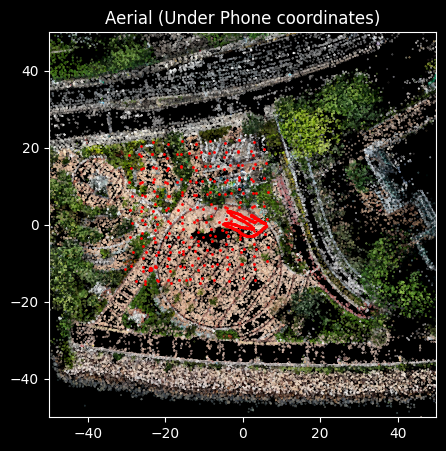

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(output_xyz[:,0], output_xyz[:,2], c=output_color/255.0, s=0.1)
plt.scatter(output_cam_centers[:,0], output_cam_centers[:,2], c='r', s=1)
plt.title('Aerial (Under Phone coordinates)')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

(-50.0, 50.0)

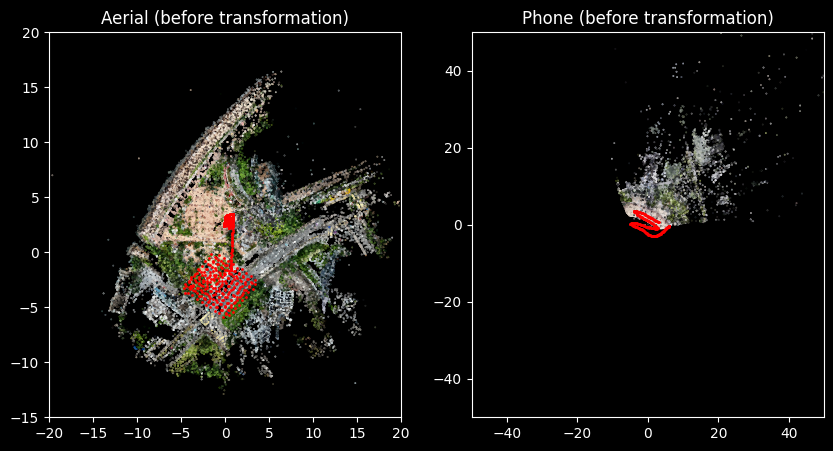

In [4]:
aerial_xyz = np.array([aerial_points[idx].xyz for idx in aerial_points])
aerial_color = np.array([aerial_points[idx].rgb for idx in aerial_points])
aerial_cam_centers = np.array([-qvec2rotmat(aerial_cameras[idx].qvec).T.dot(np.array(aerial_cameras[idx].tvec)) for idx in aerial_cameras])

phone_xyz = np.array([phone_points[idx].xyz for idx in phone_points])
phone_color = np.array([phone_points[idx].rgb for idx in phone_points])
phone_cam_centers = np.array([-qvec2rotmat(phone_cameras[idx].qvec).T.dot(np.array(phone_cameras[idx].tvec)) for idx in phone_cameras])

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(aerial_xyz[:,0], aerial_xyz[:,1], c=aerial_color/255.0, s=0.1)
plt.scatter(aerial_cam_centers[:,0], aerial_cam_centers[:,1], c='r', s=1)
plt.title('Aerial (before transformation)')
plt.xlim(-20, 20)
plt.ylim(-15, 20)

plt.subplot(122)
plt.scatter(phone_xyz[:,0], phone_xyz[:,2], c=phone_color/255.0, s=0.1)
plt.scatter(phone_cam_centers[:,0], phone_cam_centers[:,2], c='r', s=1)
plt.title('Phone (before transformation)')
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [4]:
aerial2phone = np.array([
    [2.922504,3.289219,-2.268028,-9.628083],
    [-0.002880,2.811760,4.074057,-37.961544],
    [3.995361,-2.403952,1.661942,2.546913],
    [0.000000,0.000000,0.000000,1.000000],
])

# sort camera list according to image name
name_dict = {v.name: k for k, v in aerial_cameras.items()}
image_names = list(name_dict.keys())
image_names.sort()
aerial_cameras = {name_dict[name]: aerial_cameras[name_dict[name]] for name in image_names}
aerial_cam0 = aerial_cameras[name_dict[image_names[0]]]

name_dict = {v.name: k for k, v in phone_cameras.items()}
image_names = list(name_dict.keys())
image_names.sort()
phone_cameras = {name_dict[name]: phone_cameras[name_dict[name]] for name in image_names}
phone_cam0 = phone_cameras[name_dict[image_names[0]]]

R_aerial_cam0 = qvec2rotmat(aerial_cam0.qvec)
T_aerial_cam0 = np.array(aerial_cam0.tvec)
w2c_aerial_cam0 = np.identity(4)
w2c_aerial_cam0[:3, :3] = R_aerial_cam0
w2c_aerial_cam0[:3, 3] = T_aerial_cam0
# c2w_aerial_cam0 = np.linalg.inv(w2c_aerial_cam0)

R_phone_cam0 = qvec2rotmat(phone_cam0.qvec)
T_phone_cam0 = np.array(phone_cam0.tvec)
w2c_phone_cam0 = np.identity(4)
w2c_phone_cam0[:3, :3] = R_phone_cam0
w2c_phone_cam0[:3, 3] = T_phone_cam0

# phone_xyz_a = np.concatenate([phone_xyz, np.ones((phone_xyz.shape[0], 1))], axis=1)
# phone_xyz_a = np.matmul(phone_xyz_a, w2c_phone_cam0.T)
# phone_xyz_a = np.matmul(phone_xyz_a, phone2aerial.T)
# phone_xyz_a = np.matmul(phone_xyz_a, c2w_aerial_cam0.T)

phone_xyz_c = np.concatenate([phone_xyz, np.ones((phone_xyz.shape[0], 1))], axis=1)
# phone_xyz_c = np.matmul(phone_xyz_c, w2c_phone_cam0.T)

aerial_xyz_p = np.concatenate([aerial_xyz, np.ones((aerial_xyz.shape[0], 1))], axis=1)
aerial_xyz_p = np.matmul(aerial_xyz_p, aerial2phone.T)

In [22]:
# writes aerial_xyz_p to .ply file
with open('aerial_p.ply', 'w') as f:
    f.write('ply\n')
    f.write('format ascii 1.0\n')
    f.write('element vertex {}\n'.format(aerial_xyz_p.shape[0]))
    f.write('property float x\n')
    f.write('property float y\n')
    f.write('property float z\n')
    f.write('property uchar red\n')
    f.write('property uchar green\n')
    f.write('property uchar blue\n')
    f.write('end_header\n')
    for i in range(aerial_xyz_p.shape[0]):
        f.write('{} {} {} {} {} {}\n'.format(aerial_xyz_p[i, 0], aerial_xyz_p[i, 1], aerial_xyz_p[i, 2], aerial_color[i, 0], aerial_color[i, 1], aerial_color[i, 2]))

(-15.0, 20.0)

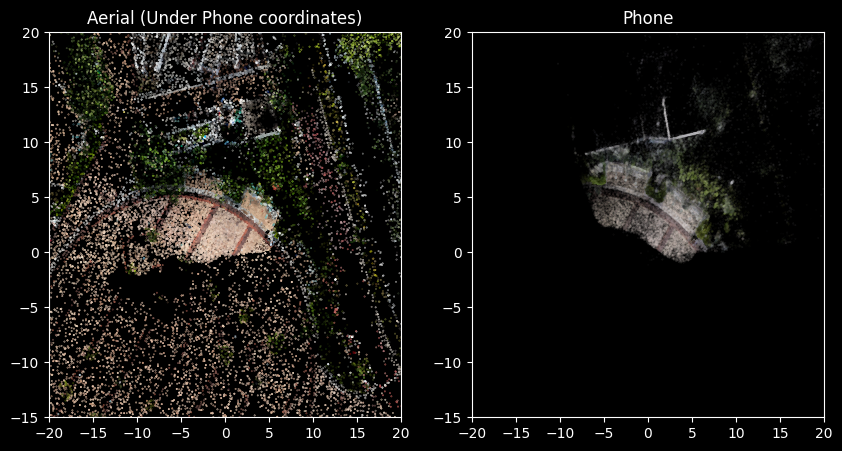

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(aerial_xyz_p[:,0], aerial_xyz_p[:,2], c=aerial_color/255.0, s=0.1)
plt.title('Aerial (Under Phone coordinates)')
plt.xlim(-20, 20)
plt.ylim(-15, 20)

plt.subplot(122)
plt.scatter(phone_xyz_c[:, 0], phone_xyz_c[:, 2], c=phone_color/255.0, s=0.1, alpha=0.1)
plt.title('Phone')
plt.xlim(-20, 20)
plt.ylim(-15, 20)

(-15.0, 20.0)

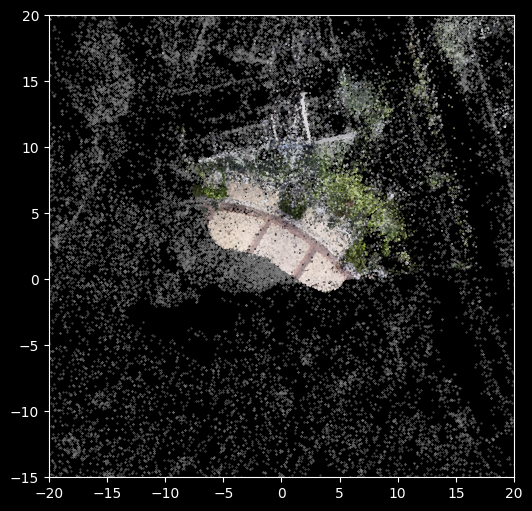

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(aerial_xyz_p[:, 0], aerial_xyz_p[:, 2], c='grey', s=0.1)
plt.scatter(phone_xyz_c[:, 0], phone_xyz_c[:, 2], c=phone_color/255.0, s=0.1)
plt.xlim(-20, 20)
plt.ylim(-15, 20)